# Traffic Light Training

## 1 Initial

In [1]:
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path = './dataset'
IMG_WIDTH = 96
IMG_HEIGHT = 96 
BATCH_SIZE = 64

## 2 Read some images

In [3]:
datagen =  ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
)

In [4]:
dataflow = datagen.flow_from_directory(
    train_path, 
    batch_size=1,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    shuffle=True,
    class_mode='categorical',
)

Found 1560 images belonging to 3 classes.


In [5]:
dataflow

In [6]:
dataflow.samples

1560

In [7]:
dataflow.classes

array([0, 0, 0, ..., 2, 2, 2])

In [8]:
dataflow.class_indices

{'Green': 0, 'Red': 1, 'Yellow': 2}

In [9]:
#圖片的array在tuple的第0個 (1,xx,xx,3)
dataflow[0][0].shape

(1, 96, 96, 3)

In [10]:
dataflow[0][0][0].shape

(96, 96, 3)

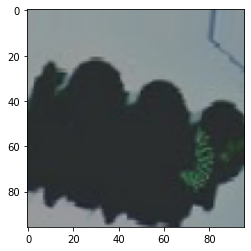

In [11]:
plt.imshow(dataflow[0][0][0])

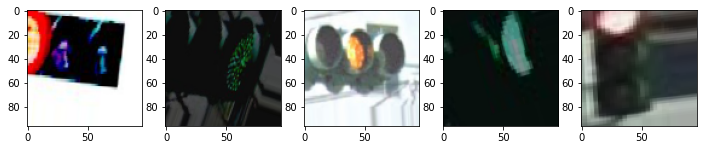

In [12]:
plt.figure(figsize=(12,10))

i = 0
for img_info in dataflow:
    x = img_info[0]
    x = x.reshape((IMG_HEIGHT, IMG_WIDTH, 3))
    plt.subplot(1, 5, i+1)
    plt.grid(False)
    plt.imshow(x)
    
    if i == 4:
        break
    i += 1
plt.show()

## 3 Read training and validation set

In [13]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    rotation_range=10,
    preprocessing_function=None,
    validation_split=0.1
)

train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

Found 1404 images belonging to 3 classes.
Found 156 images belonging to 3 classes.


## 4 Dictinary

In [15]:
train_generator.class_indices

{'Green': 0, 'Red': 1, 'Yellow': 2}

In [16]:
#提供django做對應轉換
dict_new= dict(zip(train_generator.class_indices.values(), train_generator.class_indices.keys()))
dict_new

{0: 'Green', 1: 'Red', 2: 'Yellow'}

## 5 Define CNN Model

In [17]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 92, 92, 32)        2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 43, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 21, 64)       

## 6 Compile Model

In [18]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

## 7 Check point and early stopping

In [19]:
checkpoint_filepath = './traffic_light_recognition.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    # save_weights_only=True,
    monitor='val_loss',
    mode='min',
    # monitor='val_accuracy',
    # mode='max',
    save_best_only=True,
    period=1
)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

## 8 Train

In [21]:
%%time

hist = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    verbose=1,
    #steps_per_epoch=training_data_n/BATCH_SIZE,
    #validation_steps=validation_data_n/BATCH_SIZE,
    max_queue_size=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/100
22/22 [==============================] - 10s 437ms/step - loss: 1.2709 - accuracy: 0.5905 - val_loss: 0.4776 - val_accuracy: 0.8526
Epoch 2/100
22/22 [==============================] - 5s 242ms/step - loss: 0.4060 - accuracy: 0.8668 - val_loss: 0.1983 - val_accuracy: 0.9359
Epoch 3/100
22/22 [==============================] - 5s 247ms/step - loss: 0.2930 - accuracy: 0.8932 - val_loss: 0.1015 - val_accuracy: 0.9103
Epoch 4/100
22/22 [==============================] - 6s 250ms/step - loss: 0.2430 - accuracy: 0.9231 - val_loss: 0.0655 - val_accuracy: 0.9551
Epoch 5/100
22/22 [==============================] - 6s 253ms/step - loss: 0.1564 - accuracy: 0.9437 - val_loss: 0.0955 - val_accuracy: 0.9295
Epoch 6/100
22/22 [==============================] - 6s 261ms/step - loss: 0.1548 - accuracy: 0.9530 - val_loss: 0.2549 - val_accuracy: 0.9359
Epoch 7/100
22/22 [==============================] - 6s 261ms/step - loss: 0.1267 - accuracy: 0.9623 - val_loss: 0.0609 - val_accuracy: 0.967

## 9 Evaluate

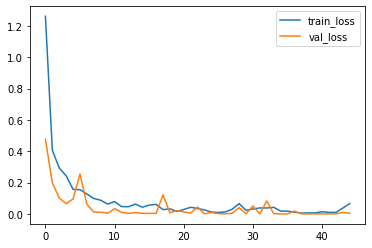

In [23]:
plt.plot(hist.history['loss'], label="train_loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

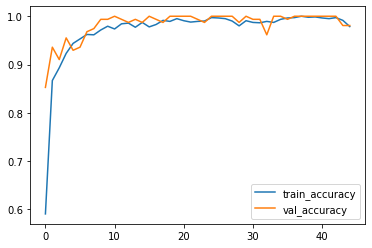

In [24]:
plt.plot(hist.history['accuracy'], label="train_accuracy")
plt.plot(hist.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()